In [13]:
import numpy
from torch.utils.data import DataLoader
from tqdm import tqdm

import matplotlib.pyplot as plt

from dataio.loader import get_dataset, get_dataset_path
from dataio.transformation import get_dataset_transformation
from utils.util import json_file_to_pyobj
from utils.visualiser import Visualiser
from utils.error_logger import ErrorLogger

from models import get_model

from torchvision.datasets import Cityscapes
from torchvision.transforms import Compose, ToTensor, Normalize, Resize

In [14]:
import numpy as np

def display_example_image(dataset):
    """
    Display an example image and its label from the dataset.
    """
    # Get the first image and label from the dataset
    image, label = dataset[0]

    # Convert the image tensor to numpy for visualization
    image_np = image.permute(1, 2, 0).numpy()  # Change dimensions to H x W x C
    image_np = np.clip(image_np * 255, 0, 255).astype(np.uint8)  # Denormalize and convert to uint8

    # Convert the label tensor to numpy and squeeze to remove the single channel
    label_np = label.squeeze(0).numpy()

    # Display the image using matplotlib
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.title("Input Image")
    plt.imshow(image_np)
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.title("Label")
    plt.imshow(label_np, cmap='gray')
    plt.axis('off')

    plt.show()

# # Add this function call to visualize an example image
# train_dataset = get_cityscapes_dataset(data_path='data', split='train', transform=get_cityscapes_transforms())
# display_example_image(train_dataset)


In [15]:
def inspect_dataset(dataset):
    image, label = dataset[0]
    print(f"Image shape: {image.shape}")
    print(f"Label shape: {label.shape}")

def get_cityscapes_transforms():
    """
    Returns separate transforms for images and labels.
    """
    image_transform = Compose([
        Resize((512, 1024)),  # Resize images to a smaller resolution
        ToTensor(),          # Convert to PyTorch tensor
        Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize for pretrained models
    ])
    
    target_transform = Compose([
        Resize((512, 1024)),  # Resize to match image size
        ToTensor()           # Convert to PyTorch tensor
    ])
    
    return image_transform, target_transform

def get_cityscapes_dataset(data_path, split, image_transform, target_transform):
    """
    Dataset setup for Cityscapes with separate transforms for image and target.
    """
    return Cityscapes(
        root=data_path,
        split=split,
        mode='fine',
        target_type='semantic',
        transform=image_transform,
        target_transform=target_transform
    )


Initialising model unet
Network is initialized
unet_2D(
  (conv1): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
  )
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): unetConv2(
    (conv1): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNo

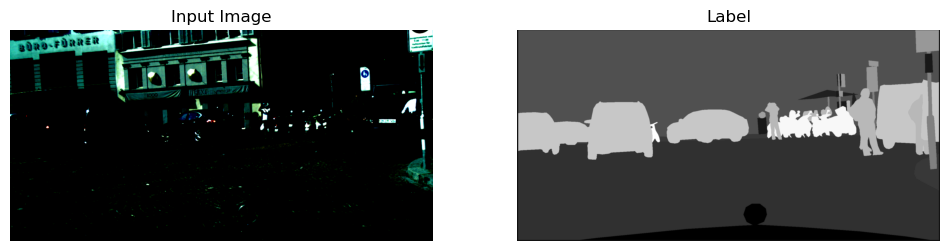

Setting up a new session...
Traceback (most recent call last):
  File "/Users/tinagong/anaconda3/envs/cs242/lib/python3.12/site-packages/urllib3/connection.py", line 199, in _new_conn
    sock = connection.create_connection(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/tinagong/anaconda3/envs/cs242/lib/python3.12/site-packages/urllib3/util/connection.py", line 85, in create_connection
    raise err
  File "/Users/tinagong/anaconda3/envs/cs242/lib/python3.12/site-packages/urllib3/util/connection.py", line 73, in create_connection
    sock.connect(sa)
ConnectionRefusedError: [Errno 61] Connection refused

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/Users/tinagong/anaconda3/envs/cs242/lib/python3.12/site-packages/urllib3/connectionpool.py", line 789, in urlopen
    response = self._make_request(
               ^^^^^^^^^^^^^^^^^^^
  File "/Users/tinagong/anaconda3/envs/cs242/lib/python3.12/site-packages/urllib

Exception in user code:
------------------------------------------------------------
opt.lr_policy = [poly]
Scheduler is added for optimiser SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    lr: 0.0001
    maximize: False
    momentum: 0.9
    nesterov: True
    weight_decay: 1e-05
)
(epoch: 0, total # iters: 372)


  0%|          | 0/372 [00:00<?, ?it/s]


AssertionError: 

In [17]:

def train(arguments):
    # Parse input arguments
    json_filename = arguments.config
    # network_debug = arguments.debug

    # Load options
    json_opts = json_file_to_pyobj(json_filename)
    train_opts = json_opts.training

    # Architecture type
    arch_type = train_opts.arch_type

    # Setup Dataset and Augmentation
    ds_class = get_dataset(arch_type)
    ds_path  = get_dataset_path(arch_type, json_opts.data_path)
    ds_transform = get_dataset_transformation(arch_type, opts=json_opts.augmentation)

    # Setup the NN Model
    model = get_model(json_opts.model)
    # if network_debug:
    #     print('# of pars: ', model.get_number_parameters())
    #     print('fp time: {0:.3f} sec\tbp time: {1:.3f} sec per sample'.format(*model.get_fp_bp_time2()))
    #     exit()

    # Setup Data Loader
    # train_dataset = ds_class(ds_path, split='train',      transform=ds_transform['train'], preload_data=train_opts.preloadData)
    # valid_dataset = ds_class(ds_path, split='val',        transform=ds_transform['valid'], preload_data=train_opts.preloadData)
    # test_dataset  = ds_class(ds_path, split='test',       transform=ds_transform['valid'], preload_data=train_opts.preloadData)
    
    # train_loader = DataLoader(dataset=train_dataset, num_workers=0, batch_size=train_opts.batchSize, shuffle=True)
    # valid_loader = DataLoader(dataset=valid_dataset, num_workers=0, batch_size=train_opts.batchSize, shuffle=False)
    # test_loader  = DataLoader(dataset=test_dataset,  num_workers=0, batch_size=train_opts.batchSize, shuffle=False)

    # Get separate transforms for images and labels
    image_transform, target_transform = get_cityscapes_transforms()

    # Setup datasets with separate transforms
    train_dataset = get_cityscapes_dataset(data_path='data', split='train', image_transform=image_transform, target_transform=target_transform)
    valid_dataset = get_cityscapes_dataset(data_path='data', split='val', image_transform=image_transform, target_transform=target_transform)
    test_dataset = get_cityscapes_dataset(data_path='data', split='test', image_transform=image_transform, target_transform=target_transform)

    inspect_dataset(train_dataset)

    # Display an example image
    display_example_image(train_dataset)

    train_loader = DataLoader(dataset=train_dataset, num_workers=4, batch_size=train_opts.batchSize, shuffle=True)
    valid_loader = DataLoader(dataset=valid_dataset, num_workers=4, batch_size=train_opts.batchSize, shuffle=False)
    test_loader = DataLoader(dataset=test_dataset, num_workers=4, batch_size=train_opts.batchSize, shuffle=False)

    # Visualisation Parameters
    visualizer = Visualiser(json_opts.visualisation, save_dir=model.save_dir)
    error_logger = ErrorLogger()

    # Training Function
    model.set_scheduler(train_opts)
    for epoch in range(model.which_epoch, train_opts.n_epochs):
        print('(epoch: %d, total # iters: %d)' % (epoch, len(train_loader)))

        # Training Iterations
        for epoch_iter, (images, labels) in tqdm(enumerate(train_loader, 1), total=len(train_loader)):
            # Make a training update
            model.set_input(images, labels)
            model.optimize_parameters()
            #model.optimize_parameters_accumulate_grd(epoch_iter)

            # Error visualisation
            errors = model.get_current_errors()
            error_logger.update(errors, split='train')

        # Validation and Testing Iterations
        for loader, split in zip([valid_loader, test_loader], ['validation', 'test']):
            for epoch_iter, (images, labels) in tqdm(enumerate(loader, 1), total=len(loader)):

                # Make a forward pass with the model
                model.set_input(images, labels)
                model.validate()

                # Error visualisation
                errors = model.get_current_errors()
                stats = model.get_segmentation_stats()
                error_logger.update({**errors, **stats}, split=split)

                # Visualise predictions
                visuals = model.get_current_visuals()
                visualizer.display_current_results(visuals, epoch=epoch, save_result=False)

        # Update the plots
        for split in ['train', 'validation', 'test']:
            visualizer.plot_current_errors(epoch, error_logger.get_errors(split), split_name=split)
            visualizer.print_current_errors(epoch, error_logger.get_errors(split), split_name=split)
        error_logger.reset()

        # Save the model parameters
        if epoch % train_opts.save_epoch_freq == 0:
            model.save(epoch)

        # Update the model learning rate
        model.update_learning_rate()


if __name__ == '__main__':
    # import argparse

    # parser = argparse.ArgumentParser(description='CNN Seg Training Function')

    # parser.add_argument('-c', '--config',  help='training config file', required=True)
    # parser.add_argument('-d', '--debug',   help='returns number of parameters and bp/fp runtime', action='store_true')
    # args = parser.parse_args()

    class Args:
        config = "configs/config_unet_ct_dsv.json"
        debug = True

    # Create an instance of the Args class
    args = Args()

    train(args)